In [1]:
from m4.ground.read_data import read_phasemap
from m4.type.measure import SurfaceMeasure, SurfaceSequence
from pathlib3x import Path
from m4.utils.osutils import FileWalker
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime as dt
from m4.ground import zernike
import pandas as pd
import copy
# from m4.ground.zernike import zernike_fit
# from m4.analyzers.noise_data_analyzer import compute_

class SurfaceSequence():
    '''
    Class to handle a sequence of surface measurements
    Usage:
    
        
        from m4.utils.osutils import FileWalker
        from m4.type.measure import SurfaceSequence, SurfaceMeasure
        
        % init
        fw = FileWalker(path)
        tn = '20230715_150944'
        fullopath = fw.findTracknum(tn)
        seq = SurfaceSequence(fullopath)
        print(seq[1].surface.std())
        
        %use static methods to load temperatures and zernikes
        aa = SurfaceMeasure.load_temperatures(fullopath[0])
        print(aa)
        aa = SurfaceMeasure.load_zernikes(fullopath[0])
        
        %slicing
        seq2 = seq[0:50]
        
        %compute structure function bulk (fitting zernike polynomials each time)
        time, stf = seq2.compute_time_stf_bulk()
        seq2.compute_intersection_mask()
        

        %compute structure function bulk (fitting zernike polynomials on intersection mask)
        time, stf = seq2.compute_fast_time_stf()
        plt.figure()
        plt.plot(time, stf)
        
        
    '''

    def __init__(self, root_dirs):

        if not isinstance(root_dirs, list):
            root_dirs = [root_dirs]

        if root_dirs[0].is_file():
            print("Sequence from file not implemented yet")
            pass

        else:
            for root_dir in root_dirs:
                if root_dir == root_dirs[0]:
                    self._root_dir = root_dir
                    self._filenames = list(
                        Path(root_dir).rglob('????????_??????.fits'))
                    tmp_tmp = SurfaceMeasure.load_temperatures(root_dir)
                    self._temperature = pd.DataFrame(
                        tmp_tmp.byteswap().newbyteorder('='))
                    tmp_zn = SurfaceMeasure.load_zernikes(root_dir)
                    self._zernike = pd.DataFrame(
                        tmp_zn.byteswap().newbyteorder('='))
                    self._tau_vector = np.array(list(map(lambda l: dt.strptime(
                        l.name[0:15], '%Y%m%d_%H%M%S'), self._filenames)))
                else:
                    self._filenames += list(
                        Path(root_dir).rglob('????????_??????.fits'))
                    tmp_tmp = SurfaceMeasure.load_temperatures(root_dir)
                    self._temperature = pd.concat(
                        [self._temperature, pd.DataFrame(tmp_tmp.byteswap().newbyteorder('='))])
                    tmp_zn = SurfaceMeasure.load_zernikes(root_dir)
                    self._zernike = pd.concat(
                        [self._zernike, pd.DataFrame(tmp_zn.byteswap().newbyteorder('='))])
                    self._tau_vector = np.concatenate(self._tau_vector, np.array(list(map(lambda l: dt.strptime(
                        str(l.name)[0:15], '%Y%m%d_%H%M%S'), self._filenames))))
            self._intersetion_mask = None

    def __len__(self):
        return len(self._filenames)

    def __getitem__(self, idx):

        if isinstance(idx, slice):
            new_seq = copy.deepcopy(self)
            new_seq._filenames = self._filenames[idx]
            new_seq._temperature = self._temperature.iloc[idx]
            new_seq._zernike = self._zernike.iloc[idx]
            new_seq._tau_vector = self._tau_vector[idx]
            return new_seq
        else:
            img_path = Path(self._filenames[idx])
            meas = SurfaceMeasure.load(img_path)
        return meas

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def __repr__(self):
        return f"SurfaceSequence({self._root_dir}  [{len(self)} frames])"

    def __str__(self):
        return self.__repr__()

    @property
    def temperture(self):
        return self._temperture

    @property
    def zernike(self):
        return self._zernike

    @property
    def tau_vector(self):
        return self._tau_vector

    @property
    def tau_vector_as_timestamp(self):
        return np.array(list(map(lambda l: dt.timestamp(l), self._tau_vector)))

    def set_tau_vector(self, tau_vector):
        if not isinstance(tau_vector, np.ndarray):
            raise TypeError("tau_vector must be a numpy array")
        if not isinstance(tau_vector[0], dt):
            raise TypeError(
                "tau_vector must be a numpy array of datetime objects")
        if len(tau_vector) != len(self):
            raise ValueError(
                "tau_vector must have the same length as the sequence")

        self._tau_vector = tau_vector

    def set_intersection_mask(self, mask):
        self._intersetion_mask = mask

    @property
    def intersection_mask(self):
        return self._intersetion_mask

    def compute_intersection_mask(self):
        for ff in self:
            
            if self._intersetion_mask is None:
                self._intersetion_mask = ff.surface.mask
            else:
                self._intersetion_mask = self._intersetion_mask | ff.surface.mask

    def compute_time_stf_bulk(self, nzern=3):
        '''Compute the structure function of the sequence of surfaces fitting the first nzern zernike polynomials'''

        if nzern is not None:
            zv = np.arange(nzern) + 1

        dtime = self.tau_vector_as_timestamp
        xx, yy = np.meshgrid(dtime, dtime)
        dd = np.sqrt((xx-xx.T)**2 + (yy-yy.T)**2)
        datalen = len(self)
        stf = np.zeros(datalen-1)
        time = np.zeros(datalen-1)

        stf_mat = np.zeros((datalen, datalen))
        for i in range(datalen):
            print(i, end=" ")

            if nzern is not None:
                coeff, mat = zernike.zernikeFit(self[i].surface, zv)
                sur = zernike.zernikeSurface(self[i].surface, coeff, mat)
                ima_i = self[i].surface - sur

            else:
                ima_i = self[i].surface

            for j in range(datalen-i):
                if nzern is not None:
                    coeff, mat = zernike.zernikeFit(self[i+j].surface, zv)
                    sur = zernike.zernikeSurface(self[i+j].surface, coeff, mat)
                    ima_ij = self[i+j].surface - sur

                else:
                    ima_ij = self[i+j].surface
                dd[i+j, j] = 0
                stf_mat[i, i+j] = np.ma.std(ima_i - ima_ij)**2
            # calculate the structure function as the average of the elements of the matrix which distance is the same
        for i in range(datalen-1):
            stf[i] = np.sqrt(np.mean(stf_mat[dd == dd[0, i]]))
            time[i] = dd[0, i]

        return time, stf

    def compute_fast_time_stf(self, nzern=3):
        '''Compute the structure function of the sequence of surfaces fitting the first nzern zernike polynomials on intersection mask'''

        if nzern is not None:
            zv = np.arange(nzern) + 1

        dtime = self.tau_vector_as_timestamp
        xx, yy = np.meshgrid(dtime, dtime)
        dd = np.sqrt((xx-xx.T)**2 + (yy-yy.T)**2)
        datalen = len(self)
        stf = np.zeros(datalen-1)
        time = np.zeros(datalen-1)

        stf_mat = np.zeros((datalen, datalen))
        if self._intersetion_mask is None and nzern is not None:
            print("Computing intersection mask")
            self.compute_intersection_mask()

        for i in range(datalen):
            print(i, end=" ")

            if nzern is not None:

                data = np.ma.masked_array(
                    self[i].surface.data, mask=self._intersetion_mask)
                if i == 0:
                    coeff, mat = zernike.zernikeFit(data, zv)
                    mat_pinv = np.linalg.pinv(mat)
                else:
                    coeff = np.dot(mat_pinv, data[data.mask == False])
                sur = zernike.zernikeSurface(data, coeff, mat)
                ima_i = data - sur

            else:
                ima_i = data

            for j in range(datalen-i):
                if nzern is not None:

                    data = np.ma.masked_array(
                        self[i+j].surface.data, mask=self._intersetion_mask)
                    coeff = np.dot(mat_pinv, data[data.mask == False])

                    sur = zernike.zernikeSurface(data, coeff, mat)
                    ima_ij = data - sur

                else:
                    ima_ij = self[i+j].surface
                dd[i+j, j] = 0
                stf_mat[i, i+j] = np.ma.std(ima_i - ima_ij)**2
            # calculate the structure function as the average of the elements of the matrix which distance is the same
        for i in range(datalen-1):
            stf[i] = np.sqrt(np.mean(stf_mat[dd == dd[0, i]]))
            time[i] = dd[0, i]

        return time, stf

    def compute_time_stf_w_preloaded_data(self, nzern=3):
        '''Compute the structure function of the sequence of surfaces using intersection mask and zernike coefficients from the folder'''

        if nzern is not None:
            zv = np.arange(nzern) + 1

        dtime = self.tau_vector_as_timestamp
        xx, yy = np.meshgrid(dtime, dtime)
        dd = np.sqrt((xx-xx.T)**2 + (yy-yy.T)**2)
        datalen = len(self)
        stf = np.zeros(datalen-1)
        time = np.zeros(datalen-1)

        stf_mat = np.zeros((datalen, datalen))
        if self._intersetion_mask is None and nzern is not None:
            print("Computing intersection mask", end="...")
            self.compute_intersection_mask()
            print("done")

        zern_coeff = self._zernike.to_numpy()
        print("Computing structure function")
        print("Frame distance:", end=" ")
        for i in range(datalen):
            print(i, end=" ")

            if nzern is not None:

                data = np.ma.masked_array(
                    self[i].surface.data, mask=self._intersetion_mask)
                if i == 0:
                    coeff, mat = zernike.zernikeFit(data, zv)
                    #print(coeff)
                    #print(zern_coeff[i, 0:nzern])
                    #print(data.mean())
                    #print(self[i].surface.mean())
                    
                    plt.imshow(data)
                    try:
                        np.testing.assert_allclose(coeff, zern_coeff[i, 0:nzern], rtol=0.1)
                    except AssertionError:
                        print("WARNING: Zernike coefficients in folder are not consistent with the data")
                sur = zernike.zernikeSurface(data, zern_coeff[i, 0:nzern], mat)
                ima_i = data - sur

            else:
                ima_i = data

            for j in range(datalen-i):
                if nzern is not None:

                    data = np.ma.masked_array(
                        self[i+j].surface.data, mask=self._intersetion_mask)
                    sur = zernike.zernikeSurface(
                        data, zern_coeff[i+j, 0:nzern], mat)
                    ima_ij = data - sur

                else:
                    ima_ij = self[i+j].surface
                dd[i+j, j] = 0
                stf_mat[i, i+j] = np.ma.std(ima_i - ima_ij)**2
            # calculate the structure function as the average of the elements of the matrix which distance is the same
        for i in range(datalen-1):
            stf[i] = np.sqrt(np.mean(stf_mat[dd == dd[0, i]]))
            time[i] = dd[0, i]

        return time, stf

In [2]:
fw = FileWalker(r"D:\M4\M4Data\OPDSeries")
tn = '20230715_150944'
fullopath = fw.findTracknum(tn)
print(fullopath)
seq = SurfaceSequence(fullopath)
print(seq[1].surface.std())

[WindowsPath('D:/M4/M4Data/OPDSeries/20230715_150944')]
1.3117531736772034e-07


In [3]:
aa = SurfaceMeasure.load_temperatures(fullopath[0])
print(aa)

[[33.54 30.54 30.82 ... 30.29 30.6  30.29]
 [33.53 30.54 30.85 ... 30.29 30.58 30.29]
 [33.53 30.54 30.84 ... 30.29 30.6  30.29]
 ...
 [33.65 30.62 30.92 ... 30.37 30.67 30.37]
 [33.65 30.62 30.91 ... 30.39 30.66 30.37]
 [33.64 30.62 30.89 ... 30.38 30.66 30.37]]


In [4]:
aa = SurfaceMeasure.load_zernikes(fullopath[0])
print(aa)
print(aa.shape)

[[ 1.43051147e-06 -2.25452299e-07 -1.41847656e-07 ... -1.08108873e-08
   1.51590550e-09 -1.52436584e-10]
 [ 5.37517095e+00 -3.36385732e-08 -1.01982781e-07 ... -9.44092652e-09
   9.63556427e-09  3.73658746e-09]
 [ 1.06624520e+01 -1.18456814e-07 -9.14390113e-08 ... -9.09300353e-09
   2.75349743e-09  2.78159677e-09]
 ...
 [ 5.25964121e+03 -8.97042037e-08 -3.86618283e-07 ... -1.14070461e-08
   8.17309169e-09  4.12741283e-09]
 [ 5.26494422e+03 -1.82669577e-07 -3.67160345e-07 ... -7.70323212e-09
   5.62800020e-09  2.81254662e-09]
 [ 5.27021575e+03  3.67616562e-07 -3.98803307e-07 ... -9.56062449e-09
   4.50956441e-09  4.12961713e-09]]
(1000, 11)


Computing intersection mask...done
Computing structure function
Frame distance: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

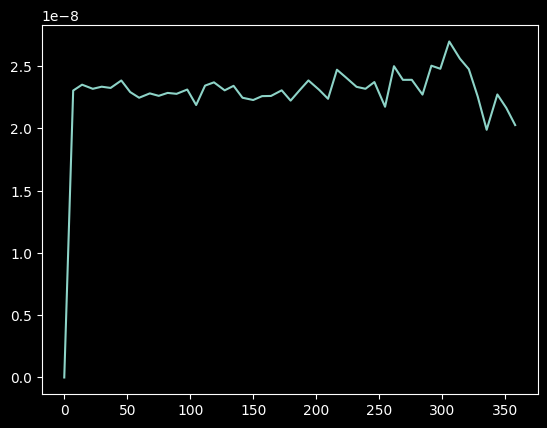

In [5]:
seq2 = seq[0:50]
#seq2.compute_intersection_mask()
#print(np.sum(seq2.intersection_mask == False))

time, stf = seq2.compute_fast_time_stf()
plt.figure()
plt.plot(time, stf)
